In [2]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler
import seaborn as sns
import rpy2.rinterface_lib.callbacks
import logging
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import  LogisticRegression
from keras.models import load_model
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from functools import partial
from sklearn.ensemble import StackingClassifier
from bayes_opt import BayesianOptimization
from rpy2.robjects import pandas2ri
from joblib import dump, load
import pickle
import anndata2ri
import anndata

In [3]:
from sklearn.metrics import precision_score, recall_score

In [4]:
import importlib
import warnings
warnings.filterwarnings("ignore")

import pickle as pkl

In [5]:
from matplotlib.colors import LinearSegmentedColormap
values = [0,1]
colors = [(227, 227, 227), (255, 42, 18)]
norm = plt.Normalize(min(values), max(values))
my_cmap = LinearSegmentedColormap.from_list(
    '', [(norm(value), tuple(np.array(color) / 255)) for value, color in zip(values, colors)])

In [6]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3

In [7]:
%%R

library(scran)
library(Seurat)

Exception ignored from cffi callback <function _consolewrite_ex at 0x0000019ED88245E0>:
Traceback (most recent call last):
  File "C:\Users\Ran\anaconda3\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "C:\Users\Ran\anaconda3\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd4 in position 0: invalid continuation byte
Exception ignored from cffi callback <function _consolewrite_ex at 0x0000019ED88245E0>:
Traceback (most recent call last):
  File "C:\Users\Ran\anaconda3\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "C:\Users\Ran\anaconda3\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

Exception ignored from cffi callback <function _consolewrite_ex at 0x0000019ED88245E0>:
Traceback (most recent call last):
  File "C:\Users\Ran\anaconda3\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 133, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "C:\Users\Ran\anaconda3\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 138, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd4 in position 1: invalid continuation byte


In [ ]:
adata = sc.read_mtx('C:/Users/Ran/Downloads/GSE164378_PBMC/GSM5008737_RNA_3P-matrix.mtx')

In [20]:
var_names = pd.read_csv('C:/Users/Ran/Downloads/GSE164378_PBMC/GSM5008737_RNA_3P-features.tsv',sep = '\t',header = None)[0]

In [31]:
obs_names = pd.read_csv('C:/Users/Ran/Downloads/GSE164378_PBMC/GSM5008737_RNA_3P-barcodes.tsv',sep = '\t',header = None)[0]

In [32]:
barcode = [i.split('_')[1] for i in obs_names]

In [34]:
adata = adata.T

In [61]:
adata.obs_names = obs_names
adata.var_names = var_names

In [36]:
atb_mat = sc.read_mtx('C:/Users/Ran/Downloads/GSE164378_PBMC/GSM5008738_ADT_3P-matrix.mtx')

In [40]:
atb_names = pd.read_csv('C:/Users/Ran/Downloads/GSE164378_PBMC/GSM5008738_ADT_3P-features.tsv',sep = '\t',header = None)[0]

In [70]:
atb_df = pd.DataFrame(atb_mat.X.A.T)
atb_df.index = obs_names.tolist()
atb_df.columns = atb_names
total_counts_per_cell = atb_df.sum(axis=0)
atb_df = atb_df.divide(total_counts_per_cell, axis=1) * 1e6
atb_df = np.log(atb_df+1)

In [71]:
adata.obs = atb_df

In [75]:
adata.obs['barcode'] = barcode

In [12]:
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
adata.obs['mt_frac'] = np.array(adata.X[:, mt_gene_mask].sum(1).ravel())[0]/adata.obs['n_counts']

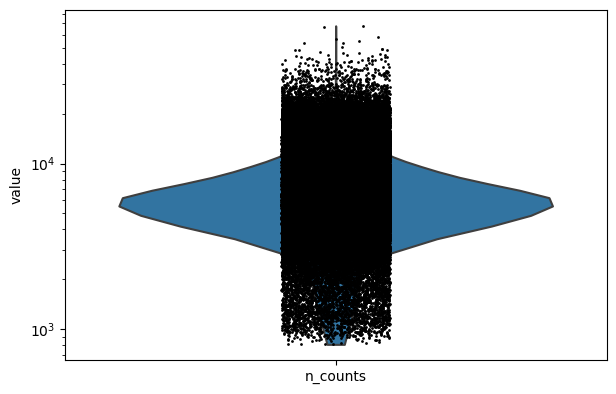

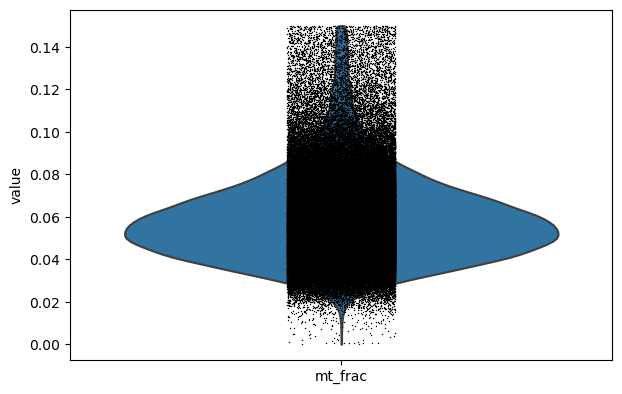

In [78]:
# Quality control - plot QC metrics
t1 = sc.pl.violin(adata, 'n_counts', size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac')

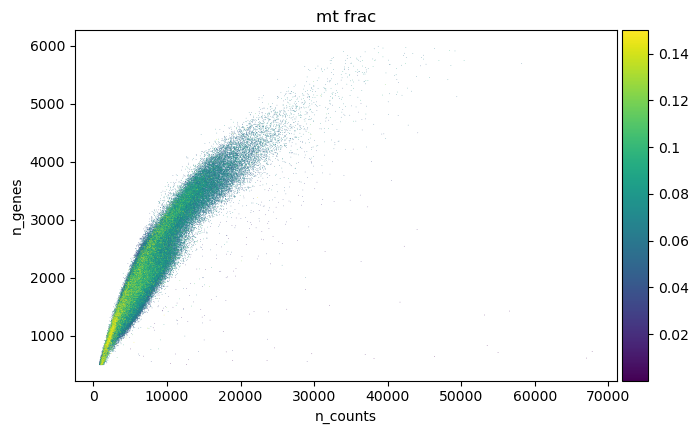

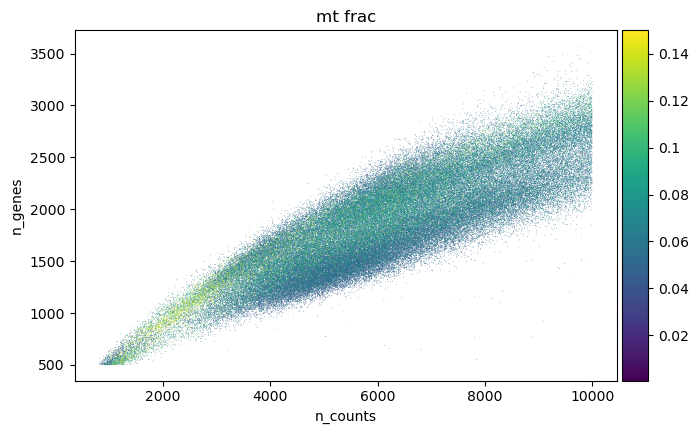

In [79]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac')

C:\Users\Ran\AppData\Local\Temp\ipykernel_8808\484377408.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p3 = sns.distplot(adata.obs['n_counts'], kde=False)


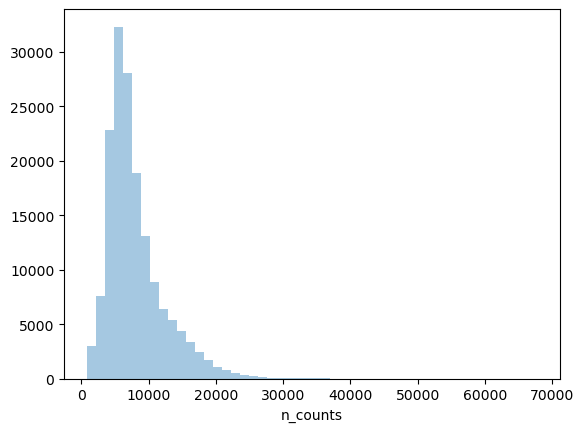

C:\Users\Ran\AppData\Local\Temp\ipykernel_8808\484377408.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p4 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=60)


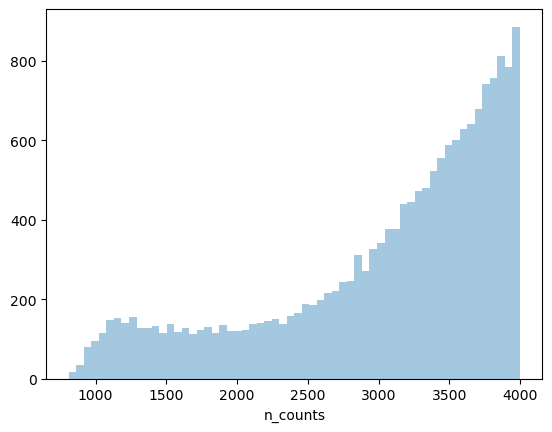

C:\Users\Ran\AppData\Local\Temp\ipykernel_8808\484377408.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p5 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60)


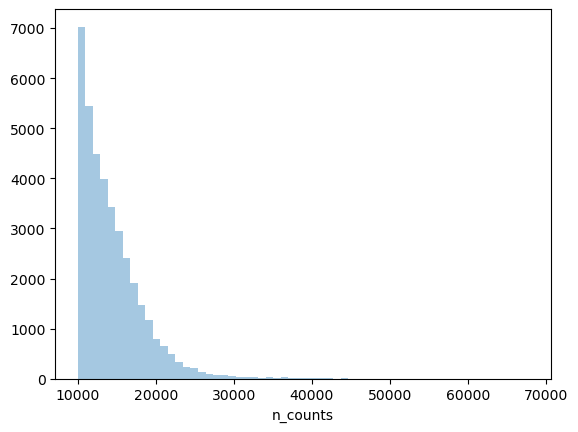

In [80]:
#Thresholding decision: counts
p3 = sns.distplot(adata.obs['n_counts'], kde=False)
plt.show()

p4 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

p5 = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts']>10000], kde=False, bins=60)
plt.show()

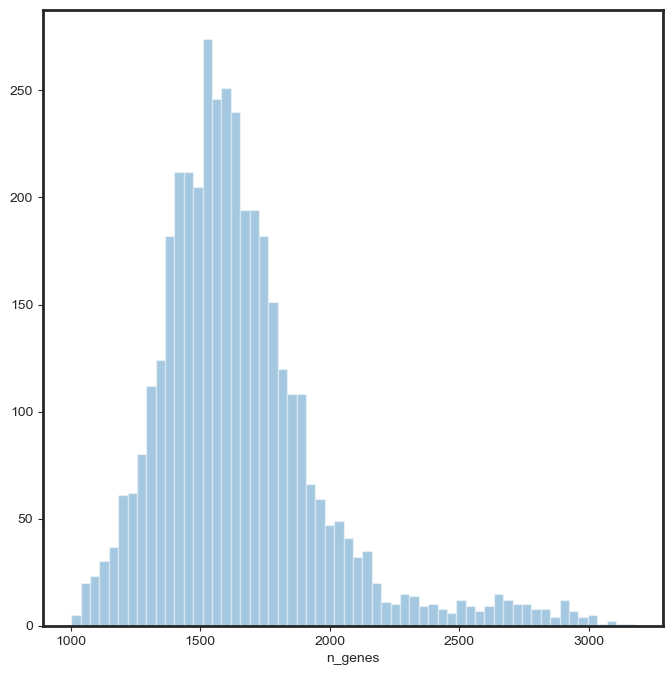

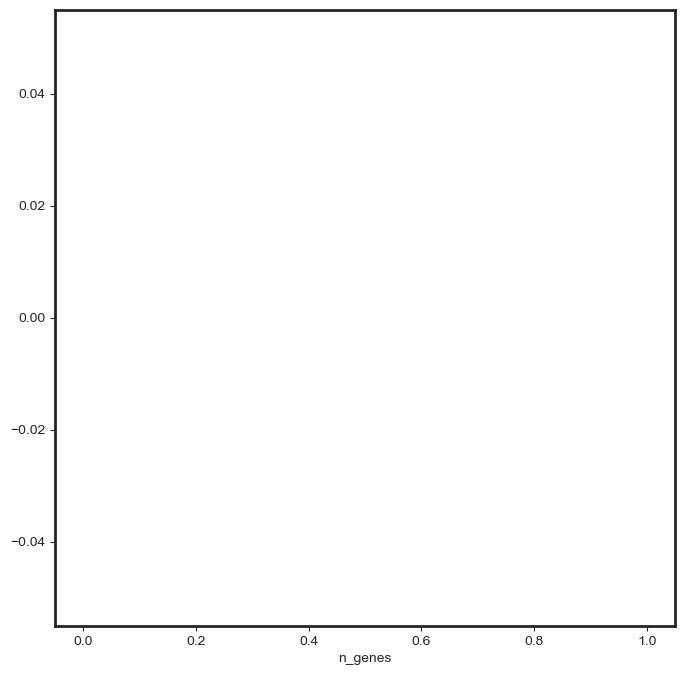

In [ ]:
p6 = sns.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sns.distplot(adata.obs['n_genes'][adata.obs['n_genes']<1000], kde=False, bins=60)
plt.show()

In [81]:
sc.pp.filter_genes(adata, min_cells = 2)

In [11]:
adata = sc.read_h5ad('unprocessed_matched.h5ad')

In [14]:
adata_forcycle = adata.copy()
sc.pp.normalize_total(adata_forcycle, key_added = 'normalization_factors')
sc.pp.log1p(adata_forcycle)

normalizing counts per cell
    finished (0:00:01)


### Use the cell cycle gene list summarized by Triosh et al. to calculate the cc score

In [15]:
cc_genes = pd.read_csv('C:/Users/Ran/Downloads/GSE164378_PBMC/Triosh_cc.csv')

In [16]:
s_genes = cc_genes['G1/S'].dropna()
g2m_genes = cc_genes['G2/M'].dropna()

s_genes_mm_ens = adata_forcycle.var_names[np.in1d(adata_forcycle.var_names, s_genes)]
g2m_genes_mm_ens = adata_forcycle.var_names[np.in1d(adata_forcycle.var_names, g2m_genes)]

In [17]:
sc.tl.score_genes_cell_cycle(adata_forcycle, s_genes=s_genes_mm_ens, g2m_genes=g2m_genes_mm_ens)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    503 total control genes are used. (0:00:04)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    503 total control genes are used. (0:00:04)
-->     'phase', cell cycle phase (adata.obs)


### Visualize the cell phases of the co-cultured cells

In [18]:
Sscore = adata_forcycle.obs['S_score'].values.tolist()
G2Mscore = adata_forcycle.obs['G2M_score'].values.tolist()
S_G2M_diff = adata_forcycle.obs['S_score'] - adata_forcycle.obs['G2M_score']
S_G2M_diff = S_G2M_diff.values.tolist()

In [19]:
adata.uns['allgenes'] = list(adata.var_names)
adata.obs['S_score'] = adata_forcycle.obs['S_score']
adata.obs['G2M_score'] = adata_forcycle.obs['G2M_score']
adata.obs['S_G2M_diff'] = adata.obs['S_score'] - adata.obs['G2M_score']
adata.obs['phase'] = adata_forcycle.obs['phase']

In [9]:
colnames = adata.obs_names
rownames = adata.var_names
mt_frac = adata.obs['mt_frac']
S_G2M_diff = adata.obs['S_score'] - adata.obs['G2M_score']
S_G2M_diff = S_G2M_diff.values.tolist()

### Construct the Seurat object

In [10]:
counts = adata.X.T

In [11]:
%R -i counts -i colnames -i rownames -i S_G2M_diff -i mt_frac

In [12]:
%%R
colnames(counts) = colnames
rownames(counts) = rownames

srat <- CreateSeuratObject(counts = counts, min.cells = 0, min.features = 0, assay = "RNA")

srat[["S_G2M_diff"]] = S_G2M_diff
srat[["mt_frac"]] = mt_frac

In [13]:
%%R
saveRDS(srat, 'GSE164378_preprocessed.rds')

## Proceed to HPC, see R script in the repository

In [5]:
%%R
srat = readRDS('srat_downsampled_stablized.rds')

In [6]:
%%R -o HVG 
HVG = VariableFeatures(srat)

In [8]:
pd.DataFrame(HVG).to_csv('HVG.csv')

In [9]:
%%R -o varExplained  -o PCs -o mat -o pca -o X_pca

mat <- Seurat::GetAssayData(object = srat, slot = 'scale.data')
pca <- srat[["pca"]]

# Get the total variance:
total_variance <- sum(matrixStats::rowVars(mat))

eigValues = (pca@stdev)^2  ## EigenValues
varExplained = eigValues / total_variance

PCs = Loadings(srat, reduction = "pca")
X_pca =pca@cell.embeddings

In [10]:
%%R -o counts -o logcounts

counts = srat[["SCT"]]@counts
logcounts = srat[["SCT"]]@data

In [11]:
%%R -o var_names -o obs_names
var_names = rownames(srat)
obs_names = colnames(srat)

In [13]:
import anndata
adata = anndata.AnnData(X = logcounts.T)
adata.var_names = var_names
adata.obs_names = obs_names
adata.uns['scaled'] = mat.T
adata.layers['counts'] = counts.T
adata.layers['logcounts'] = logcounts.T
adata.obsm['X_pca'] = X_pca

In [20]:
obs = pd.read_csv('obs.csv',index_col = 0)

In [21]:
adata.obs = obs.loc[adata.obs_names,:]

In [16]:
adata.write('seurat4_transformed.h5ad')

In [ ]:
adata = sc.read_h5ad('seurat4_transformed.h5ad')
print('Number of cells before T filter: {:d}'.format(adata.n_obs))
adata = adata[np.array(adata[:,'CD3D'].X.A>0)|np.array(adata[:,'CD3E'].X.A>0)|np.array(adata[:,'CD3G'].X.A>0)|np.array(adata[:,'CD247'].X.A>0),:]
adata = adata[np.array(adata[:,'CD19'].X.A==0),:]
print('Number of cells after T filter: {:d}'.format(adata.n_obs))
sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution = 0.5)
sc.tl.paga(adata, groups='leiden')
sc.pl.paga(adata,threshold = 0.2, labels=None, fontsize = 10, fontoutline = 3,node_size_scale = 3,node_size_power = 1,random_state = 0)
sc.tl.umap(adata, min_dist = 0.01, spread = 2,init_pos = 'paga')
#two-peaks thresholding is a classic question in image processing so I just borrow their function
t = skimage.filters.threshold_otsu(adata.obs['CD45RA'].values)
print("Found automatic threshold t = {}.".format(t))
CD45RA_neg = adata[adata.obs['CD45RA']<=t-0.5]
CD45RA_pos = adata[adata.obs['CD45RA']>=t+0.5]
adata = CD45RA_pos.concatenate(CD45RA_neg, batch_key = 'CD45RA_label',batch_categories=['Positive', 'Negative'])

In [16]:
adata.write('GSE164378_processed.h5ad.h5ad')